# Aula 13 - DBSCAN

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) DBSCAN
- 2) Aplicação - clusterização de estações

In [1]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

____
____
_____

## 1) DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma vantagem enorme é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

Vamos entender o funcionamento do algoritmo mais a fundo!

O DBSCAN têm como princípio fundamental a **determinação de regiões de alta densidade de observações**, que são **separadas entre si por regiões de baixa densidade**.

Lembrando que, por ser um algoritmo não-supervisionado de clusterização, quando nos referimos à "regiões" cuja densidade será aferida, estamos nos referindo a regiões **do espaço de features**.

Uma pergunta natural é: **como determinar a densidade de uma região?** Para responder esta pergunta, precisamos de algumas definições:

> **Densidade em um ponto $P$:** número de pontos dentro de um círculo de raio $\epsilon$ centrado no ponto $P$ (região chamada de vizinhança-$\epsilon$ de $P$);

> **Região densa**: dizemos que uma região é densa se o círculo de raio $\epsilon$ contém pelo menos um número mínimo de pontos (que chamaremos de $\text{minPts}$. Uma região densa **formará um cluster**.

Para visualizar as definições acima, considere a figura a seguir:

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontoa centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo -- e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados -- muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;
<br>
Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.
<br>
Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.
<br>
Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).



__________

Agora que entendemos os princípios e principais hiperparâmetros do DBSCAN, vamos agora entender os passos do algoritmo (que é bem simples!)

> **Passo 1**: o algoritmo escolhe aleatoriamente um dos pontos, e sua vizinhança-$\epsilon$ é calculada;

> **Passo 2**: se este ponto tem $\text{minPts}$ em sua vizinhança-$\epsilon$, a formação do cluster é iniciada (veja próximo passo). Se não, o ponto é marcado como outlier (mas pode ser considerado como border point de um outro cluster posteriormente). Se for um outlier, volte ao passo 1;

> **Passo 3**: se o ponto for um core point, todos os pontos na vizinhança são agregados ao cluster, e o passo 1 é aplicado a cada um deles;

> **Passo 4**: o processo do passo 3 é continuado até que todos os pontos tenham um cluster associado, ou seja marcado como noise.

Podemos visualizar a seguir o DBSCAN em funcionamento:



<img src="https://ml-explained.com/_nuxt/img/dbscan.4e37192.gif" width=300>


<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


A classe do sklearn é esta: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


Vamos agora ver o DBSCAN em ação, com o mesmo dataset artificial da aula passada!

____


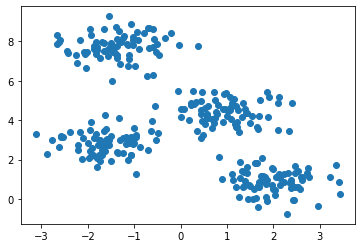

In [2]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

plt.scatter(X[:,0], X[:,1])

In [3]:
# 1) - importando a classe dbscan do sklearn

from sklearn.cluster import DBSCAN

In [4]:
# 2) instanciando o modelo

estimador = DBSCAN()

In [5]:
# 3) e 4) treinando o modelo

modelo = estimador.fit(X)

In [6]:
# 5) fazendo previsões

labels = modelo.labels_

labels

array([ 2,  0,  1,  0,  2, -1,  3,  1,  0,  0,  3,  0,  1,  0,  2,  1,  1,
        2,  3,  3,  2,  2,  1,  3,  3, -1,  2,  1,  3,  1,  0,  0,  1,  0,
        0,  0,  0,  0,  3,  2,  1,  3, -1,  1,  3,  3,  0,  3,  0,  2,  3,
        2,  0,  2,  2,  3,  0,  3,  0,  2,  0,  1, -1,  3,  3,  3,  0,  2,
        0,  3,  1,  3,  0,  3,  3,  0,  3,  1,  2,  0,  2,  1,  2,  2,  0,
        1,  2,  1, -1,  0,  1,  2,  0,  3,  3,  1,  2,  2,  1,  3,  0,  2,
        0,  2,  1,  2,  2,  1,  0,  1,  3,  3,  2,  0,  2,  1,  0,  2,  2,
        1,  3,  2,  3,  2,  2,  2,  2,  3,  2,  3,  0,  3,  3,  2,  0,  3,
        3,  0,  1,  0,  0,  3,  1, -1,  1,  3,  0,  1,  0,  0,  0,  1, -1,
        1,  2,  3,  0,  3,  2,  1,  0,  1,  1,  2,  1,  3, -1,  1,  2,  1,
        1,  0,  2,  1, -1,  0,  2,  2,  1,  3,  2,  1,  3,  3,  1,  1,  1,
        1,  2,  0,  1,  3,  1,  1,  3,  3,  3,  1,  3,  0,  1,  3,  2,  3,
        1, -1,  3,  0,  1,  0,  1,  3,  1,  1,  0,  3,  3,  2, -1,  1,  0,
        2,  2,  3,  2,  3

In [7]:
pd.Series(modelo.labels_).unique()

array([ 2,  0,  1, -1,  3], dtype=int64)

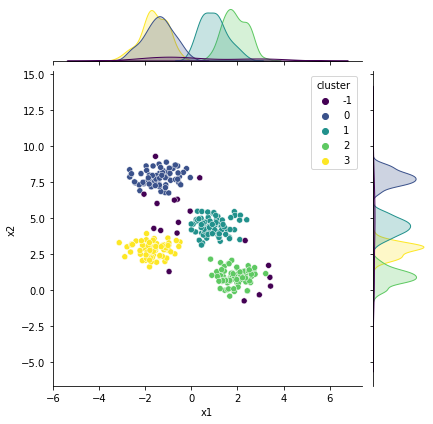

In [8]:
# plotando os clusters

dados_clusterizados = pd.concat([pd.DataFrame(X, columns=["x1", "x2"]), 
                                 pd.Series(labels, name="cluster")], axis=1)

sns.jointplot(data=dados_clusterizados, x="x1", y="x2", hue="cluster", palette="viridis")

plt.show()

Quem são os outliers??

In [9]:
dados_clusterizados[dados_clusterizados["cluster"] == -1].index

Int64Index([  5,  25,  42,  62,  88, 143, 152, 166, 174, 205, 218, 242, 249,
            256, 273, 274, 290, 298],
           dtype='int64')

Tirando os outliers.. Os clusters continuam os mesmos!

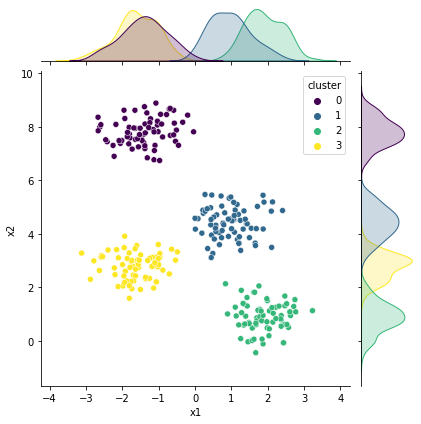

In [10]:
X_sem_noise = X[dados_clusterizados[dados_clusterizados["cluster"] != -1].index]

estimador = DBSCAN()

modelo = estimador.fit(X_sem_noise)

labels = modelo.labels_

dados_clusterizados = pd.concat([pd.DataFrame(X_sem_noise, columns=["x1", "x2"]), 
                                 pd.Series(labels, name="cluster")], axis=1)

sns.jointplot(data=dados_clusterizados, x="x1", y="x2", hue="cluster", palette="viridis")

plt.show()

Mudando os hiperparâmetros...

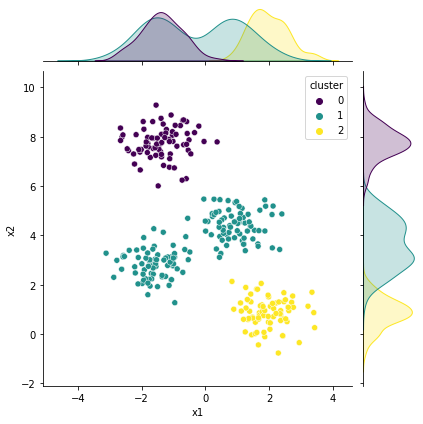

In [11]:
estimador = DBSCAN(eps=0.8, min_samples=5)

modelo = estimador.fit(X)

labels = modelo.labels_

dados_clusterizados = pd.concat([pd.DataFrame(X, columns=["x1", "x2"]), 
                                 pd.Series(labels, name="cluster")], axis=1)

sns.jointplot(data=dados_clusterizados, x="x1", y="x2", hue="cluster", palette="viridis")

plt.show()

____
____
_____

## 2) Aplicação - clusterização de estações

Vamos pegar os dados geográficos das estações da malha de transporte metropolitano de SP, e ver uma aplicação interessante do DBSCAN

In [12]:
# Valeu, squad amarela!!!

df = pd.read_csv("../datasets/metroetrem_sp_comlinks.csv")

In [13]:
df.head()

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46723768,-23586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46708157,-23571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46701610,-23567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46694102,-23567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46684259,-23566228,FRADIQUE COUTINHO,OSCAR FREIRE


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 17
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   num_lin      196 non-null    int64 
 1   nome_lin     196 non-null    object
 2   long         196 non-null    int64 
 3   lat          196 non-null    int64 
 4   estacao_upp  196 non-null    object
 5   link         196 non-null    object
dtypes: int64(3), object(3)
memory usage: 10.7+ KB


In [15]:
# transformando em números

df["long"] = df["long"].apply(lambda x: x/10**(len(str(x))-3))
df["lat"] = df["lat"].apply(lambda x: x/10**(len(str(x))-3))

In [16]:
df

,num_lin,nome_lin,long,lat,estacao_upp,link
0,4,AMARELA,-46.723768,-23.586440,SAO PAULO MORUMBI,BUTANTA
1,4,AMARELA,-46.708157,-23.571857,BUTANTA,PINHEIROS
2,4,AMARELA,-46.701610,-23.567392,PINHEIROS,FARIA LIMA
3,4,AMARELA,-46.694102,-23.567269,FARIA LIMA,FRADIQUE COUTINHO
4,4,AMARELA,-46.684259,-23.566228,FRADIQUE COUTINHO,OSCAR FREIRE
...,...,...,...,...,...,...
13,3,VERMELHA,-46.530926,-23.531906,VILA MATILDE,GUILHERMINA ESPERANCA
14,3,VERMELHA,-46.516730,-23.529421,GUILHERMINA ESPERANCA,PATRIARCA VILA RE
15,3,VERMELHA,-46.501354,-23.531229,PATRIARCA VILA RE,ARTUR ALVIM
16,3,VERMELHA,-46.484555,-23.540371,ARTUR ALVIM,CORINTHIANS ITAQUERA


In [20]:
colors = {'AMARELA': '#f0d20e',
          'AZUL': '#0515a3',
          'CORAL': '#e07000',
          'DIAMANTE': '#919190',
          'ESMERALDA': '#0bd6a3',
          'JADE': '#0bd637',
          'LILAS': '#a659de',
          'PRATA': '#616161',
          'RUBI': '#9c2438',
          'SAFIRA': '#0c0880',
          'TURQUESA': '#267587',
          'VERDE': '#048a37',
          'VERMELHA': '#d10202'}

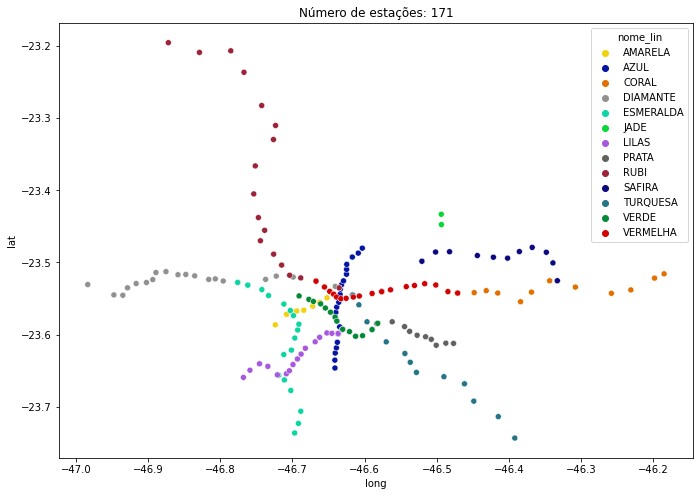

In [22]:
# plotando

plt.figure(figsize=(16, 8))

n_estacoes = df["estacao_upp"].nunique()

plt.title(f"Número de estações: {n_estacoes}")

sns.scatterplot(data=df, x="long", y="lat", hue="nome_lin", palette=colors)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

<img src="https://i.redd.it/6jxo08iuzpxy.gif" width=500>

In [23]:
# features: lat e long

X = df[["lat", "long"]].copy()

X

,lat,long
0,-23.586440,-46.723768
1,-23.571857,-46.708157
2,-23.567392,-46.701610
3,-23.567269,-46.694102
4,-23.566228,-46.684259
...,...,...
13,-23.531906,-46.530926
14,-23.529421,-46.516730
15,-23.531229,-46.501354
16,-23.540371,-46.484555


Vamos usar a [distância de Haversine](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

Importante: primeiro ponto é a latitude, segundo é a longitude!

In [24]:
# pra usar a distância de haversine, os ângulos precisam ser dados em radianos

X_train = np.radians(X).copy()

X_train

,lat,long
0,-0.411661,-0.815484
1,-0.411407,-0.815211
2,-0.411329,-0.815097
3,-0.411326,-0.814966
4,-0.411308,-0.814794
...,...,...
13,-0.410709,-0.812118
14,-0.410666,-0.811870
15,-0.410697,-0.811602
16,-0.410857,-0.811309


In [26]:
eps_km = 3
km_to_rad = 6371.0088

eps = eps_km/km_to_rad

eps

0.0004708830413167849

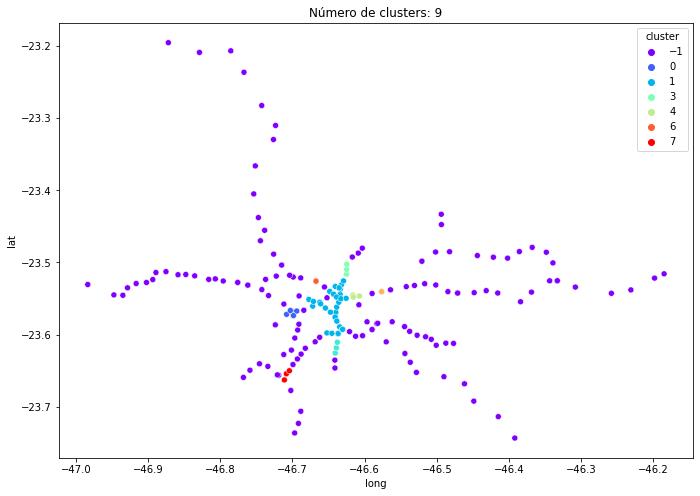

In [32]:
from sklearn.cluster import DBSCAN

# https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data
eps_km = 1
km_to_rad = 6371.0088

eps = eps_km/km_to_rad

db = DBSCAN(eps=eps, metric="haversine", algorithm="ball_tree", min_samples=3).fit(X_train)

X["cluster"] = db.labels_

#################################################################

# plotando
plt.figure(figsize=(16, 8))

n_cluster = X["cluster"].nunique()

plt.title(f"Número de clusters: {n_cluster}")

sns.scatterplot(data=X, x="long", y="lat", hue="cluster", palette="rainbow")

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Com o k-means...

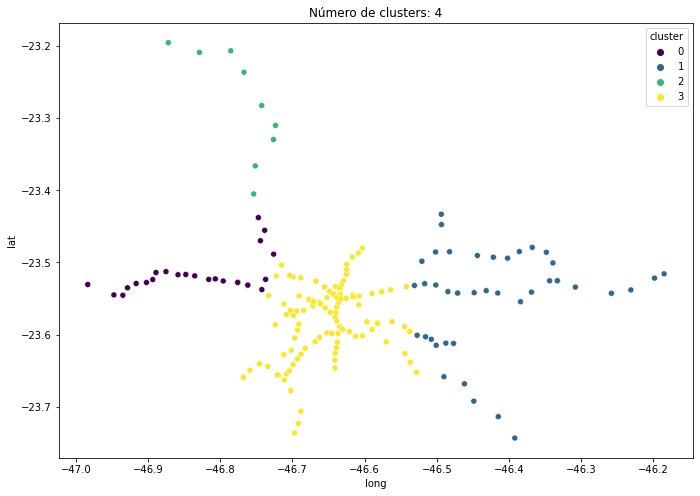

In [28]:
# k-means

from sklearn.cluster import KMeans

km = KMeans(n_clusters=4).fit(X_train)

X["cluster"] = km.labels_

#################################################################

plt.figure(figsize=(16, 8))

n_cluster = X["cluster"].nunique()

plt.title(f"Número de clusters: {n_cluster}")

sns.scatterplot(data=X, x="long", y="lat", hue="cluster", palette="viridis")

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

________

Variação hierárquica do dbscan: [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html). Sugestão do Giovani! ;)